In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from bs4 import BeautifulSoup as bs

import requests
from urllib.request import urlopen, Request 
from path import Path, getcwdu

import glob
import os
from pathlib import PurePath
import copy


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, recall_score

In [2]:
train_file_list = [PurePath(file).name for file in glob.iglob('data/nc_training_filings/*')]
train_path_list = [PurePath(os.getcwd()).joinpath(file).as_posix() for file in glob.iglob('data/nc_training_filings/*')]
train_accession_ids = [PurePath(file).stem for file in train_file_list]
train_cik_nbrs = [x.split(sep='-')[0] for x in train_accession_ids]

In [3]:
val_accession_ids = train_accession_ids[300:]

### Exploring the train.csv

In [4]:
srp_df = pd.read_csv('data/share_repurchase_paragraphs.csv').sort_values('accession_number').reset_index()

In [5]:
srp_df['para_len'] = srp_df['paragraph_text'].apply(lambda x: len(x))

In [6]:
srp_df = srp_df.drop_duplicates()

In [7]:
srp_df.columns

Index(['index', 'ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units', 'paragraph_text',
       'para_len'],
      dtype='object')

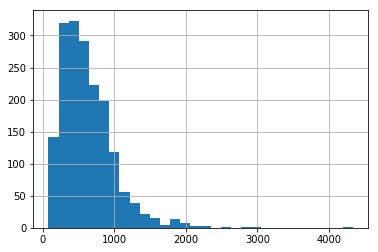

In [8]:
srp_df.para_len.hist(bins=30)
plt.show()

In [9]:
srp_df.data_key_friendly_name.value_counts()

Share Repurchase Authorization Date    401
Share Repurchase Authorization         369
Amount Spent on Share Repurchases      329
Share Repurchase Count                 286
Share Repurchase Intention             227
Unknown Share Repurchase Data          122
Share Repurchase Utilization            47
Name: data_key_friendly_name, dtype: int64

Helper function for viewing paragraph text in training dataframe

In [10]:
def print_row_detail(df=srp_df, nrow=10, header_list = ['ticker', 'accession_number' ],
                    detail_list = ['data_key_friendly_name', 'text', 'paragraph_text'],
                    sortby=['accession_number', 'data_key_friendly_name'], ascending=True):
    df_sorted = df.sort_values(sortby, ascending=ascending).reset_index()
    nrow = min(len(df_sorted), nrow)
    for i in range(0, nrow):
        for h in header_list:
            print('-'*35  + ' ' +  str(df_sorted[h][i]) + ' ' + '-'*35)
        for d in detail_list:
            print(d + '  :' + str(df_sorted[d][i]))
            print('')

In [11]:
print_row_detail(df=srp_df[srp_df.accession_number == '0001564590-18-002832'], sortby=['para_len'], ascending=False)

----------------------------------- TXN -----------------------------------
----------------------------------- 0001564590-18-002832 -----------------------------------
data_key_friendly_name  :Amount Spent on Share Repurchases

text  :Stock repurchases

paragraph_text  :For Years Ended December 31,   (Millions of   dollars, except   share and per-share   amounts)                   2017              2016              2015              2014              2013   Cash flow data:   Cash flows from   operating activities   $      5,363      $      4,614      $      4,397      $      4,054      $      3,514   Capital expenditures            695               531               551               385               412   Free cash flow (a)            4,668             4,083             3,846             3,669             3,102   Dividends paid                2,104             1,646             1,444             1,323             1,175   Stock repurchases             2,556             2,132       

#### Examine records with long paragraph length

In [12]:
srp_df.sort_values(['para_len'], ascending=False).head()

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
309,1273,PEP,0000077476-18-000012,Share Repurchase Count,Share repurchases,18000000,18.0,millions,2017 2016 20...,4332
311,1279,PEP,0000077476-18-000012,Amount Spent on Share Repurchases,Share repurchases,2000000000,2000.0,millions,2017 2016 20...,4332
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.0,millions,"For Years Ended December 31, (Millions of ...",3017
392,1645,UTX,0000101829-18-000005,Amount Spent on Share Repurchases,Repurchases of Common Stock ^3,1453000000,1453.0,millions,"(dollars in millions, except per share amounts...",2899
1478,1126,MMM,0001558370-18-000535,Share Repurchase Intention,"Total January 1-December 31, 2017",5070000000,5070.0,millions,Maximum ...,2536


In [13]:
srp_df[srp_df.accession_number == '0001564590-18-002832']

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1576,1599,TXN,0001564590-18-002832,Share Repurchase Intention,stock repurchase authorizations remain,9240000000,9.24,billions,Treasury shares were acquired in connection wi...,223
1577,1595,TXN,0001564590-18-002832,Share Repurchase Authorization,board of directors authorized the purchase of ...,6000000000,6.00,billions,All open-market purchases during the quarter w...,348
1578,1596,TXN,0001564590-18-002832,Share Repurchase Authorization Date,"September 21, 2017",20170921,20200000.00,ones,All open-market purchases during the quarter w...,348
1579,1597,TXN,0001564590-18-002832,Share Repurchase Count,repurchase,30600000,30.60,millions,"In 2017, financing activities used $3.73 billi...",764
1580,1594,TXN,0001564590-18-002832,Share Repurchase Authorization,authorization,7500000000,7.50,billions,All open-market purchases during the quarter w...,348
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.00,millions,"For Years Ended December 31, (Millions of ...",3017


In [14]:
print_row_detail(df = srp_df[srp_df.ticker=='GOOGL'], ascending=False)

----------------------------------- GOOGL -----------------------------------
----------------------------------- 0001652044-18-000007 -----------------------------------
data_key_friendly_name  :Share Repurchase Utilization

text  :aggregate amount

paragraph_text  :During 2017, we repurchased and subsequently retired 5.2 million shares of Alphabet Class C capital stock for   an aggregate amount of $4.8 billion

----------------------------------- GOOGL -----------------------------------
----------------------------------- 0001652044-18-000007 -----------------------------------
data_key_friendly_name  :Share Repurchase Intention

text  :December 1 - 31

paragraph_text  :Total Number of Shares                                                              Purchased as Part of     Approximate Dollar Value                   Total Number of                             Publicly Announced      of Shares that May Yet Be                 Shares Purchased (in  Average Price Paid   Programs (in 

### Testing patterns and functions for creating "documents" from sections of html files

In [15]:
repurch_pat_list = [r"authorized the (re)?purchase",
r"repurchas(e|es|ed)( authoriz\w+)?",
r"[^0-9a-z]ASR",
r"Shares (re)Purchased",
r"Share buyback",
r"common stock purchase",
r"purchase an additional",
r"remaining share"]
repurch_pats = [re.compile(x, re.I) for x in repurch_pat_list]

In [16]:
repurch_pat = re.compile(r'authorized the purchase|repurchas(e|es|ed)|[^0-9a-z]ASR|Shares Purchased|Share buyback|common stock purchase|purchase an additional|remaining share', flags=re.I)

In [17]:
df_pat = re.compile(r'.*(authorized the purchase|repurchase|[^0-9a-z]ASR|Shares Purchased|Share buyback|common stock purchase|purchase an additional|remaining share).*', flags=re.I)
#missed_df = srp_df[srp_df.paragraph_text.str.match(df_pat) == False]
missed_df = srp_df[(srp_df.paragraph_text.str.match(df_pat) == False) & (srp_df.text.str.match(df_pat) == False)]

hit_df = srp_df[(srp_df.paragraph_text.str.match(df_pat) == True) | (srp_df.text.str.match(df_pat) == True)]

In [18]:
len(hit_df.accession_number.unique())

431

In [19]:
print_row_detail(df=missed_df[missed_df.data_key_friendly_name =='Amount Spent on Share Repurchases'], ascending=False)

----------------------------------- CLX -----------------------------------
----------------------------------- 0001628280-17-008700 -----------------------------------
data_key_friendly_name  :Amount Spent on Share Repurchases

text  :Evergreen Program

paragraph_text  :2017                       2016                       2015                     Amount  Shares (in 000's)  Amount  Shares (in 000's)  Amount  Shares (in 000's)   Evergreen Program $ 189         1,505        $ 254         2,151        $ 434         4,016

----------------------------------- SLB -----------------------------------
----------------------------------- 0001564590-18-000821 -----------------------------------
data_key_friendly_name  :Amount Spent on Share Repurchases

text  :2017

paragraph_text  :(Stated in thousands, except per share amounts)        Total Cost    Total Number   Average Price         of Shares     of Shares       Paid per         Purchased     Purchased         Share   2017 $   968,676      

In [20]:
missed_df[['data_key_friendly_name', 'accession_number']].groupby('data_key_friendly_name').count()

,accession_number
data_key_friendly_name,
Amount Spent on Share Repurchases,15
Share Repurchase Authorization,7
Share Repurchase Authorization Date,33
Share Repurchase Count,16
Share Repurchase Intention,21
Share Repurchase Utilization,3
Unknown Share Repurchase Data,5


In [21]:
missed_df.text.value_counts()

2017                                                                                    11
Total                                                                                    8
December 2017                                                                            7
December 31, 2017                                                                        5
December 2016                                                                            4
purchased                                                                                4
2016                                                                                     3
December 15, 2015                                                                        3
December 1 - 31, 2017                                                                    2
Fiscal Year 2017                                                                         2
November 2017                                                                            2

This table was identifed as a paragraph. The word sequence doesn't work. The div above it clearly talks about share repurchase and "following table." 

In [22]:
missed_df[(missed_df.accession_number == '0001628280-18-001872') & (
    missed_df.data_key_friendly_name == 'Share Repurchase Intention') ].paragraph_text.apply(
lambda x: re.sub(r' +', ' ', x)).values
#values.astype('str')[0].re.su



array(['(millions, except per share data) (d) (c) Approximate Total Dollar Number Value of of Shares Shares (a) Purchased that May Total (b) as Part of Yet Be Number Average Publicly Purchased of Price Announced Under the Shares Paid Per Plans or Plans or Period Purchased Share Programs Programs Month #1: 10/01/17-10/28/17 - - - $ 558 Month #2: 10/29/17-11/25/17 - - - $ 558 Month #3: 11/26/17-12/30/17 - - - $ 558'],
      dtype=object)

In [23]:
srp_df[(srp_df.accession_number == '0001628280-18-001872')]

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1721,947,K,0001628280-18-001872,Share Repurchase Authorization,a new authorization by the board of directors ...,1500000000,1.5,billions,"In December 2015, the board of directors appro...",360
1722,950,K,0001628280-18-001872,Share Repurchase Intention,11/26/17-12/30/17,558000000,558.0,millions,"(millions, except per share data) ...",1034
1723,949,K,0001628280-18-001872,Amount Spent on Share Repurchases,for a total of,516000000,516.0,millions,"During 2017, the Company repurchased 7 million...",305
1724,948,K,0001628280-18-001872,Share Repurchase Authorization Date,December 2017,20171215,20200000.0,ones,(123 ) (339 ) Non-cash charges and other ...,262
1725,946,K,0001628280-18-001872,Share Repurchase Count,repurchased,7000000,7.0,millions,"During 2017, the Company repurchased 7 million...",305


In [ ]:
#https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000002969&type=10-K&dateb=20171031&owner=include&count=40

### Functions for extracting candidate documents from an html file

Function to create and index a dataframe from an html table. Empty cells are removed.

In [30]:
def df_from_html_tbl(table_tag):
    data_re = re.compile(r'[a-zA-Z0-9$().]+')
    repl = re.compile(r'[()$]')
    rows = []
    for row in table_tag.findChildren('tr'):
        row_list = []
        for s in row.strings:
            s = re.sub(repl, '', s.strip())
            if len(s) > 0:
                row_list.append(s)
        if len(row_list) > 1:
            rows.append(row_list)
    tbl_df = pd.DataFrame.from_records(rows)
    try:
        tbl_df = tbl_df.set_index( tbl_df.applymap(len).max().values.argmax()) 
    except: tbl_df = tbl_df.set_index(0)
    return tbl_df

In [31]:
def get_repurch_hits(filepath):
    try:
        with open(filepath, encoding="utf8") as file: 
            file_html = file.read()
            soup = bs(file_html, 'lxml')
    except: 
        with open(filepath) as file: 
            file_html = file.read()
            soup = bs(file_html, 'lxml')
    soup_repurch = soup.body.find_all(string=[repurch_pat])
    text_dict = {} 
    df_dict = {}
    html_dict = {}
    html_list = []
    for idx, item in enumerate(soup_repurch):
        if item.find_parent('table') is None:
            if len(item.parent.parent.text) < 2000: 
                if item.parent.parent not in html_list:
                    tag = copy.copy(item.parent.parent)
                    text_dict[idx] = tag.get_text(' ', strip=True)
                    html_dict[idx] = tag
                    html_list.append(tag)
            elif item.parent not in html_list:
                tag = copy.copy(item.parent)
                text_dict[idx] = tag.get_text(' ', strip=True)
                html_dict[idx] = tag
                html_list.append(tag)
        elif item.find_parent('table') not in html_list:
            tag = copy.copy(item.find_parent('table'))
            text_dict[idx] = tag.get_text(' ', strip=True)
            html_dict[idx] = tag
            html_list.append(tag)
            try:
                df_dict[idx] = df_from_html_tbl(tag)
            except:
                if len(item.parent.parent.text) < 2000: 
                    if item.parent.parent not in html_list:
                        tag = copy.copy(item.parent.parent)
                        text_dict[idx] = tag.get_text(' ', strip=True)
                        html_dict[idx] = tag
                        html_list.append(tag)
                elif item.parent not in html_list:
                    tag = copy.copy(item.parent)
                    text_dict[idx] = tag.get_text(' ', strip=True)
                    html_dict[idx] = tag
                    html_list.append(tag)
    doc_dict = {'text' : text_dict, 
                'html' : html_dict,
               'df' : df_dict}
    return doc_dict 

#### Errors in table parsing to work out

In [24]:
 with open(train_path_list[134], encoding="utf8") as file: 
            file_html = file.read()
            err_soup = bs(file_html, 'lxml')
err_soup_repurch = err_soup.find_all(string=[repurch_pats])

In [25]:
err_tbl_dict = {}
for idx, item in enumerate(err_soup_repurch):
    if item.find_parent('table') is not None:
        err_tbl_dict[idx] = item.find_parent('table')


In [26]:
for k, v in err_tbl_dict.items():
    try: 
        df_from_html_tbl(err_tbl_dict[k])
    except: 
        print("key number " + str(k) + " causes an error")

key number 3 causes an error
key number 4 causes an error
key number 12 causes an error
key number 13 causes an error
key number 14 causes an error
key number 15 causes an error
key number 18 causes an error
key number 19 causes an error
key number 20 causes an error


In [27]:
print(err_tbl_dict[4].prettify())

<table cellpadding="0" cellspacing="0" class="c115">
 <tr>
  <td colspan="5" valign="bottom">
  </td>
 </tr>
 <tr>
  <td class="c117" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
  <td class="c118" valign="bottom">
  </td>
 </tr>
 <tr>
  <td class="c8" colspan="5" valign="bottom">
   <div class="c114">
    ² In March 2018, our Board of Directors approved an increase in the stock repurchase
authorization for fiscal 2018 by $200 million to $1.075 billion, up from the previously available $875 million
as of February 3, 2018.
   </div>
  </td>
 </tr>
</table>



In [30]:
#get_repurch_hits(train_path_list[107])

{'df': {3:                                       1      2      3     4
  0                                                          
  2017                               2016   2015   None  None
  Shares Repurchased   Units in\nMillions     39     38    26
  Cost of Shares      Dollars in Millions  1,970  1,056   804,
  7:                                                                1  \
  0                                                                  
  Fourth Quarter                  Total Number of Shares Purchased   
  Beginning Balance                                      7,696,097   
  October 1 - October 31, 2017                             165,307   
  November 1 - November 30, 2017                         1,560,559   
  December 1 - December 31, 2017                         2,261,847   
  Ending Balance                                         3,987,713   
  
                                                             2  \
  0                                             

## Create dictionary of documents parsed from html files : `para_dict`

In [32]:
para_dict = {}
for acc_id, file in zip(train_accession_ids[:], train_path_list[:]):
    para_dict[acc_id] = get_repurch_hits(file)

In [40]:
 sorted([[4,5,3], [7,8,9], [4,2,6]])

[[4, 2, 6], [4, 5, 3], [7, 8, 9]]

In [22]:
len(para_dict.keys())

435

In [23]:
len(train_accession_ids)

435

Count of "text" entries that are actually tables, and that have corresponding "df" entries

In [24]:
df_count = 0
df_key_dict = {}
df_keys = {}
for k in para_dict.keys():
    df_key_list = []
    for k2 in para_dict[k]['text'].keys():
        if k2 in para_dict[k]['df'].keys():
            df_count +=1
            df_key_list.append(k2)
    df_key_dict[k] = df_key_list
print(df_count)


2807


### Test and refine regex patterns for flagging likely relevant documents

In [25]:
def check_regex_match(pattern, text_list):
    for idx, s in enumerate(text_list):
        mo = re.search(pattern, s)
        if mo:
            ms = mo.span()[1]
            print("------    " + str(idx) + "   Matched!    -----")
            print('str length  :' + str(len(s)) + '    match span  :' + str(ms))
            print(s[:ms])
            print('')
            print(s[ms:])
            print(re.search(pattern, s))
        else:
            print("------    " + str(idx) + "  NO MATCH    -----")
            print(s)

In [26]:
test_list = ["On December 11, 2017, we announced a new repurchase plan for up to $18 billion of common stock, replacing the plan previously authorized in 2016.", 
"On December 11, 2017, the Board approved a new repurchase plan for up to $18,000 of common stock", 
"In February 2018, the Company's Board of Directors approved a new standing share repurchase authorization, whereby the Company may repurchase up to 20 million shares of its common stock through December 31, 2020 .", 
"In June 2016, Applied's Board of Directors approved a common stock repurchase program authorizing up to $2.0 billion in repurchases, which followed the completion of a $3.0 billion common stock repurchase program approved in April 2015. In September 2017, Applied's Board of Directors approved an additional common stock repurchase program authorizing up to an additional $3.0 billion in repurchases. At October 29, 2017 , $3.6 billion remained available for future stock repurchases under these repurchase programs.", 
"On December 11, 2017, we announced a new repurchase plan for up to $18 billion of common stock", 
"On February 15, 2016, the Board of Directors of the Company approved an increase to the current authorization for the stock repurchase program by $600.0 million to $1.0 billion in the aggregate. In the aggregate, our Board of Directors has authorized us to repurchase $6.2 billion of our common stock under the program. ", 
"At December 31, 2017, the amount available under the share repurchase plan, announced on December 11, 2017 , totaled $18 billion"
]

#### Actual patterns currently being used to label documents as relevant

In [27]:
pat_list = [r"Board( of Directors)?( has)? authorized the repurchase", 
r"(on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?", 
r"((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)?",       
r"Board( of Directors)?( has)? (approved|authorized) a( new)? (share|stock) repurchase program", 
r"Board( of Directors)? approved an( additional)? increase in the stock repurchase",
r"share repurchase authorization (remain|remained|by the board)",
r"shares (rep|p)urchased as Part of Public", 
r"accelerated share repurchase",     
r"(re)?purchase(d)?[,]? (up to )?(an aggregate |in aggregate, |a )?(total )?(of )?((up to|approximately) )?(([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?)(and (([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?))?(shares )?of ((our|its|the|/w+[']s) ){1,2}common stock",
r"Shares (remaining )?that May Yet Be Purchased", 
r"(authorized|approved) a share repurchase program", 
r"authorized the repurchase of (shares|up to)", 
r"authorized repurchases of up to ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )shares",
r"authorized share repurchase program", 
r"authorization replace(d|s) (the|all|any) prior repurchase authorization", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)? shares were repurchased", 
r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of (\w+([']s)? )?Common Stock",
r"repurchased ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) (million )?(common )?shares", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )? stock repurchase",
r"(Company|we) (repurchased|purchased) (approximately )?([$])?([0-9]{,4}[.]?[0-9]{,4}) million shares", 
r"we did not repurchase any shares", 
r"(shares|amount) ((available|remaining) )((for|under|the|share) ){1,5}repurchase ((\w+)[,]? ){0,4}share repurchase((\w+)[,]? ){1,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)?( share(s)?)?",            
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?under ((the|our|publicly announced) ){0,3}((authoriz/w+|program(s)?|share|repurchase)\s?){1,4}",
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?to be repurchase",
r"million common shares remaining under the", 
r"remai(n|ned|ning) under (our|the) share repurchase (authorization|program)", 
r"The Company currently plans to (rep|p)urchase ([$]?)([0-9]{,4}[.]?[0-9]{,4}) ((m|b)illion )?(to ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion )?(shares|of its common stock)",
r"(approximately )?([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion ((shares|of|our|common|stock) ){0,5}remai(ned|n) (available|under the authorization|authorized)",
r"ha(d|s) (approximately )([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion remaining under ((the|this ))?repurchase authorization",
        
           ]

reg_list = [re.compile(x, re.I) for x in pat_list]

In [28]:
#r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of AIG Common Stock"
check_regex_match(r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of (\w+([']s)? )?Common Stock",
                 ['• approximately $6.3 billion to repurchase approximately 100 million shares of AIG Common Stock; and', 
                 'repurchase programs approved by the Board of Directors in June 2016 and in September 2017, which authorized up to an aggregate of $5.0 billion in repurchases'])


------    0   Matched!    -----
str length  :100    match span  :95
• approximately $6.3 billion to repurchase approximately 100 million shares of AIG Common Stock

; and
<_sre.SRE_Match object; span=(2, 95), match='approximately $6.3 billion to repurchase approxim>
------    1  NO MATCH    -----
repurchase programs approved by the Board of Directors in June 2016 and in September 2017, which authorized up to an aggregate of $5.0 billion in repurchases


Patterns used to filter after initial regex

In [29]:
nonum_pats = [r"^[^\d]*$",
    r"^[^\d]*\d{1,2}[^\d]*$", 
    r"^([^\d]+(\d{1,2}[^\d]{2,}){1,5}\d{1,3}[^\d]*)$",
    r"^((\d{1,3}[^\d]{2,}){1,4}\d{1,2}[^\d]*)$"]
year_and_num = re.compile(r"20[0-2][0-9].*[0-9]{1,3}.*|[0-9]{1,3}.*20[0-2][0-9]", re.I)
nonum_regs = [re.compile(x) for x in nonum_pats]

In [43]:
# After reading back in, the html needs to be parsed again
#tbl_html_df = pd.read_csv('tbl_html_df.csv')
#tbl_html_df['tbl_html'] = tbl_html_df2.tbl_html.apply(lambda x: bs(x, 'lxml'))

### Assign documents to positive and negative lists based on regex; also clean text

In [30]:
pos_list = []; pos_key_list = []; neg_list = []; neg_key_list = [];
pos_keys = set(); neg_keys = set()

space_pat = re.compile(r"\s+")
para_dict_2 = {}
for idx, k in enumerate(para_dict.keys()):
    doc_dict = {}
    text_dict = {}
    for k2, v2 in para_dict[k]['text'].items():
        para = re.sub(space_pat, ' ', para_dict[k]['text'][k2].replace('\n', ' ')).replace(' ,',',')
        # Remove texts that match exclusion patterns
        if not any(reg.search(para) for reg in nonum_regs) and k2 not in para_dict[k]['df'].keys():
            text_dict[k2] = para
            if any(reg.search(para) for reg in reg_list):
                pos_list.append(para)
                pos_key_list.append(k)
                pos_keys.add(k)
            else:
                neg_list.append(para)
                neg_key_list.append(k)
                neg_keys.add(k)
    doc_dict['text'] = text_dict
    para_dict_2[k] = doc_dict
#    idx += 1
#    if idx >= 300:
#        break

In [31]:
pos_tup_train = [(pos_key_list[i], pos_list[i]) for i,v in enumerate(pos_key_list) if v not in val_accession_ids]
pos_tup_val = [(pos_key_list[i], pos_list[i]) for i,v in enumerate(pos_key_list) if v in val_accession_ids]
neg_tup_train = [(neg_key_list[i], neg_list[i]) for i,v in enumerate(neg_key_list) if v not in val_accession_ids]
neg_tup_val = [(neg_key_list[i], neg_list[i]) for i,v in enumerate(neg_key_list) if v  in val_accession_ids]

In [32]:
neg_key_list_train, neg_list_train = ([k[0] for k in neg_tup_train], [k[1] for k in neg_tup_train])
neg_key_list_val, neg_list_val = ([k[0] for k in neg_tup_val], [k[1] for k in neg_tup_val])
pos_key_list_train, pos_list_train = ([k[0] for k in pos_tup_train], [k[1] for k in pos_tup_train])
pos_key_list_val, pos_list_val = ([k[0] for k in pos_tup_val], [k[1] for k in pos_tup_val])

54 keys keys missed out of 300 covered  (11 if table texts are included) (2 only had table paragraphs)

In [33]:
print('total paragraphs with positive hits: ' + str(len(pos_list)))
print('training paragraphs with positive hits: ' + str(len(pos_list_train)))
print('training keys with positive hits: ' + str(len(set(pos_key_list_train))) + ' out of 300')
print('validation keys with positive hits: ' + str(len(set(pos_key_list_val))) + ' out of 135')

total paragraphs with positive hits: 1098
training paragraphs with positive hits: 764
training keys with positive hits: 246 out of 300
validation keys with positive hits: 112 out of 135


In [34]:
print('total paragraphs with no regex match: ' + str(len(neg_list)))
print('training paragraphs with no regex match: ' + str(len(neg_list_train)))
print('training keys with paragraphs labeled negative: ' + str(len(set(neg_key_list_train))) + ' out of 300')
print('validation keys with paragraphs labeled negative: ' + str(len(set(neg_key_list_val))) + ' out of 135')

total paragraphs with no regex match: 3161
training paragraphs with no regex match: 2240
training keys with paragraphs labeled negative: 294 out of 300
validation keys with paragraphs labeled negative: 133 out of 135


List of keys with no paragraphs flagged as relevant by the regex

In [35]:
missed_keys = [key for key in neg_keys if key not in pos_keys ]

Used for manually labeling documents as relevant or not

In [28]:
def print_docs_from_list(key_list: list=neg_key_list, doc_list: list=neg_list, start: int=0, ndocs: int=50):
    end = start + ndocs
    for idx, tup in enumerate(zip(key_list[start:end], doc_list[start:end])):
        print(str(idx + start) + '   ------   ' + str(tup[0]))
        print(tup[1])

NameError: name 'neg_key_list' is not defined

In [1633]:
neg_list_year_and_num = [s for s in neg_list[:100] if re.search(year_and_num, s)]

In [124]:
print_docs_from_list(pos_list, pos_key_list, 150, 2)

150   ------   During 2017, the Company repurchased 11.5 million shares of its common stock for total consideration of $900 million . In November 2016, the Board of Directors of the Company authorized the Company to repurchase up to $2.5 billion of the Company's common stock, which superseded any prior authorizations. The Company remains authorized to purchase additional shares of its common stock up to a value of approximately $1.5 billion . There is no time limit on the authorization. During 2016, the Company purchased 12.7 million shares of its common stock for total consideration of $800 million .
0000062709-18-000007
151   ------   In May 2017, our Board of Directors authorized the repurchase, for retirement, of up to $1.5 billion of shares of our common stock in open-market transactions or otherwise, replacing the previous Board of Directors authorization established in 2014. During 2017, we repurchased and retired 9.2 million shares of our common stock (including 0.9 million sha

35 files are included in the labeled negative documents

In [37]:
# Keys covered by first 200 entries
print(len(set(pos_key_list[:200])))
print(len(set(neg_key_list[:200])))

69
35


In [38]:
false_pos_indices = []
false_neg_indices = []

Make dataframe out of dictionaries, lists

In [39]:
#### Only keys with html tables that were converted to dataframes
tbl_keys_list = [k for k in para_dict.keys() if len(para_dict[k]['df'].keys()) > 0]

In [40]:
#### Table html 
tbl_html_list = [copy.copy(para_dict[k]['html'][k2]) for k in tbl_keys_list for k2 in para_dict[k]['df'].keys() ]
#### Corresponding key
tbl_key_list = [k for k in tbl_keys_list for k2 in para_dict[k]['df'].keys() ] 

In [41]:
#### Make dataframe
tbl_html_df = pd.DataFrame(data = { 'acc_id': tbl_key_list, 'tbl_html': tbl_html_list, 'split' : 'train' })
tbl_html_df.loc[tbl_html_df.acc_id.isin(val_accession_ids),'split'] = 'val'

In [42]:
#### Write to csv for later use
#tbl_html_df.to_csv('tbl_html_df.csv')

In [43]:
# After reading back in, the html needs to be parsed again
#tbl_html_df = pd.read_csv('tbl_html_df.csv')
#tbl_html_df['tbl_html'] = tbl_html_df2.tbl_html.apply(lambda x: bs(x, 'lxml'))

Change from markdown to code if (re)creating `paragraph_input_df` 

In [44]:
paragraph_input_dict = {'acc_id' : pos_key_list + neg_key_list, 
                       'para_text' : pos_list + neg_list, 
                        'len' : [len(p) for p in pos_list] + [len(n) for n in neg_list],
                       'label' : [1 for p in pos_list] + [0 for n in neg_list], 
                       'split' : 'train'}

paragraph_input_df = pd.DataFrame(paragraph_input_dict, columns=['acc_id', 'para_text','len','split', 'label'])

paragraph_input_df.loc[paragraph_input_df.acc_id.isin(val_accession_ids),'split'] = 'val'
#paragraph_input_df.to_csv('paragraph_input_df.csv')

In [45]:
#paragraph_input_df = pd.read_csv('paragraph_input_df.csv', index_col=0)

In [46]:
paragraph_input_df.head(2)

,acc_id,para_text,len,split,label
0,0000002969-17-000039,"On 15 September 2011, the Board of Directors a...",654,train,1
1,0000002969-17-000039,"On 15 September 2011, the Board of Directors a...",282,train,1


### EDA of paragraphs in para_dict_2

In [47]:
doc_count_2 = 0
for k in para_dict_2.keys():
    doc_count_2 +=  len(para_dict_2[k]['text'].keys())
print("There are " + str(len(para_dict_2.keys())) + " keys in para_dict_2.")
print("There are " + str(doc_count_2) + " paragraphs in para_dict_2.")     

There are 435 keys in para_dict_2.
There are 4259 paragraphs in para_dict_2.


Function to add summary dict about specific sub-dict (in this case, about text dictionaries for each file)

In [48]:
def add_subdict_summary(dict_name: dict, key: str, key_to_summarize: str ='text'):
    #Evaluate length of items in subdict
    length_dict = {}
    for k, t in dict_name[key][key_to_summarize].items():
        length_dict[k] = len(t)
    dict_name[key]['length'] = length_dict
    smry_dict = {}
    lengths = list(dict_name[key]['length'].values())
    if len(lengths) == 0:
        stats_lengths = [0]
    else: 
        stats_lengths = lengths
    smry_dict['id'] = key
    smry_dict['cnt'] = len(lengths)
    smry_dict['min'] = min(stats_lengths)
    smry_dict['median'] = np.median(stats_lengths)
    smry_dict['max'] = np.max(stats_lengths)
    smry_dict['mean'] = np.mean(stats_lengths)
    smry_key_list_name = key_to_summarize + '_keys'
    smry_dict[smry_key_list_name] = list(dict_name[key][key_to_summarize].keys())
    dict_name[key]['len_smry'] = smry_dict

In [49]:
for k in para_dict_2.keys():
    add_subdict_summary(para_dict_2, k)

In [50]:
len_cols = ['id','cnt',  'min', 'median', 'max', 'mean', 'text_keys']
len_df = pd.DataFrame([para_dict_2[x]['len_smry'] for x in para_dict_2.keys()], columns=len_cols)

Lengths of the text sections pulled from the html

In [51]:
len_df.describe()

,cnt,min,median,max,mean
count,435.000000,435.000000,435.000000,435.000000,435.000000
mean,9.790805,233.602299,587.691954,1329.498851,651.723067
std,6.545826,181.975705,224.712044,614.957649,218.481460
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,118.000000,442.500000,954.500000,496.928571
50%,9.000000,187.000000,547.000000,1232.000000,615.285714
75%,12.000000,288.500000,691.500000,1620.000000,763.288889
max,64.000000,1340.000000,1510.500000,5567.000000,1510.500000


#### Several files have way too many documents

In [52]:
len_df.sort_values('cnt', ascending=False).head(7)

,id,cnt,min,median,max,mean,text_keys
70,0000072971-18-000272,64,57,1258.0,2717,1221.562500,"[0, 2, 3, 21, 23, 24, 27, 29, 30, 32, 33, 35, ..."
272,0001104659-18-026815,63,62,578.0,3023,823.428571,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
66,0000070858-18-000009,34,83,579.5,1641,639.176471,"[2, 5, 10, 12, 13, 15, 20, 21, 22, 24, 25, 29,..."
137,0000750556-18-000079,32,128,610.5,1943,765.531250,"[2, 9, 11, 12, 15, 16, 19, 21, 24, 28, 30, 31,..."
170,0000859737-17-000023,32,165,721.5,1494,720.406250,"[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
177,0000877890-18-000025,30,128,915.5,2727,950.166667,"[0, 1, 2, 4, 6, 9, 12, 18, 19, 20, 22, 23, 25,..."
194,0000912242-18-000004,28,219,671.0,1706,783.107143,"[0, 1, 2, 3, 10, 11, 12, 13, 17, 23, 28, 33, 3..."


A lot of long, irrelevant texts were pulled out of this filing

In [53]:
def print_subdict_items(dict_of_dicts: dict, dict_key: str, max_items: int=0, text_key: str='text'):
    for idx, v in enumerate(dict_of_dicts[dict_key][text_key].items()):
        if max_items:
            if idx >= max_items:
                break
        print(str(idx))
        print(dict_of_dicts[dict_key]['length'][v[0]])
        print(v[1])
        print('')

In [54]:
print_subdict_items(para_dict_2, '0000072971-18-000272',2)

0
722
DIVIDENDS The dividend restrictions discussions on page 3 of this report and in the 2017 Annual Report to Stockholders under "Financial Statements - Notes to Financial Statements - Note 3 (Cash, Loan and Dividend Restrictions)" are incorporated into this item by reference. REPURCHASES OF EQUITY SECURITIES In January 2016, our Board of Directors authorized the repurchase of 350 million shares of our common stock. The authorization covers shares repurchased to meet team member benefit plan requirements. The Company maintains a variety of retirement plans for its team members and typically is a net issuer of shares of common stock to these plans. From time to time, it also purchases shares of common stock from these

1
1066
plans to accommodate team member preferences. Share repurchases are subtracted from the Company's repurchase authority without offset for share issuances. Shares may be repurchased as part of employee stock option exercises, from the different benefit plans or in

Count of "text" entries that are actually tables, and that have corresponding "df" entries

In [55]:
df_count_2 = 0
df_key_dict_2 = {}
df_keys_2 = {}
for k in para_dict_2.keys():
    df_key_list = []
    for k2 in para_dict_2[k]['text'].keys():
        if k2 in para_dict[k]['df'].keys():
            df_count_2 +=1
            df_key_list.append(k2)
    df_key_dict_2[k] = df_key_list
print(df_count_2)


0


Add cleaned paragraph text to lists

### Dataframes showing which regex-document matches 

In [56]:

def make_reg_list_dict(reg_list=reg_list, pat_list=pat_list, pos_list=pos_list, neg_list=neg_list, n_per_class=0):
    reg_list_dict = {}
    if not n_per_class:
        n_pos = len(pos_list); n_neg = len(neg_list)
    else: 
        n_pos, n_neg = n_per_class
    reg_list_dict['hit'] = np.ones(len(pos_list[:n_pos])).tolist() + np.zeros(len(neg_list[:n_neg])).tolist()
    for idr, reg in enumerate(reg_list):
        reg_matches = np.zeros(len(pos_list[:n_pos] + neg_list[:n_neg]))
        for idx, para in enumerate(pos_list[:n_pos] + neg_list[:n_neg]):
            if reg.search(para):
                reg_matches[idx] = 1
        reg_list_dict[pat_list[idr]] = reg_matches
    reg_list_dict['para'] = pos_list[:n_pos] + neg_list[:n_neg]
    return reg_list_dict

In [57]:
reg_list_dict = make_reg_list_dict(pos_list=pos_list_train, neg_list=neg_list_train)

In [58]:
reg_df_cols = ['hit'] + [key for key in reg_list_dict.keys() if key not in ['hit', 'para']] + ['para']
reg_hit_df = pd.DataFrame(reg_list_dict, columns=reg_df_cols)
reg_hit_df['hit_sum'] = reg_hit_df[reg_hit_df.columns[1:-1]].apply(np.sum, axis=1)

reg_hit_df['fp'] = np.where(reg_hit_df.index.isin(false_pos_indices), 1, 0)
reg_hit_df['id'] = reg_hit_df.index.values
reg_hit_df['fn'] = np.where(reg_hit_df.index.isin([x + 200 for x in false_neg_indices]), 1, 0)

In [59]:
fp_cols = ['fp','hit' ,'shares of (its|our) common stock', 'paras']
for col in reg_hit_df.columns[1:-1]:
    print(reg_hit_df[reg_hit_df.hit_sum == 1].groupby('hit')[col].sum().to_frame())
    #print(str(reg_hit_df.groupby('hit')[col].sum().to_frame()) )


     Board( of Directors)?( has)? authorized the repurchase
hit                                                        
1.0                                               12.0     
     (on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?
hit                                                                                                                                                                                                                                                                                     

In [50]:
reg_unique_hit_counts = reg_hit_df[reg_hit_df.hit_sum == 1].groupby('hit').sum()[reg_hit_df.columns[1:-5]].melt(
    var_name = 'regex', value_name = 'paras').sort_values('paras', ascending=False)

In [189]:
reg_unique_hit_counts[reg_unique_hit_counts.paras == 0].regex.tolist()

['The Company currently plans to (rep|p)urchase ([$]?)([0-9]{,4}[.]?[0-9]{,4}) ((m|b)illion )?(to ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion )?(shares|of its common stock)',
 'million common shares remaining under the',
 'authorization replace(d|s) (the|all|any) prior repurchase authorization',
 '(shares|amount) ((available|remaining) )((for|under|the|share) ){1,5}repurchase ((\\w+)[,]? ){0,4}share repurchase((\\w+)[,]? ){1,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)?( share(s)?)?',
 '([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )? stock repurchase',
 "(on|in|at|as of) (jan\\w+|feb\\w+|march|april|may|june|july|august|sept\\w+|novem\\w+|decem\\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|progra

In [199]:
fp_cols = ['fp','hit' ,'shares of (its|our) common stock', 'paras']
for col in reg_hit_df.columns[1:-1]:
    #print(reg_hit_df[reg_hit_df.hit_sum == 1].groupby('hit')[col].sum().to_frame())
    print(reg_hit_df[reg_hit_df.hit==1.0].groupby('hit')[col].sum() )


hit
1.0    95.0
Name: Board( of Directors)?( has)? authorized the repurchase, dtype: float64
hit
1.0    6.0
Name: (on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?, dtype: float64
hit
1.0    6.0
Name: ((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Co

In [1266]:
#reg_hit_df[reg_hit_df.hit_sum == 1][fp_cols].sort_values(['fp','hit'], ascending=False)
print_row_detail(df=reg_hit_df[(reg_hit_df.fn == 1) ], nrow=30, header_list=['id'], 
                 detail_list=['fp','hit' ,'accelerated share repurchase', 'para'], 
                 sortby=['fp','hit', 'accelerated share repurchase'], ascending=False)

----------------------------------- 276 -----------------------------------
fp  :0

hit  :0.0

accelerated share repurchase  :0.0

para  :Years Ended December 31, (in millions) 2017 2016 2015 (a) Aggregate repurchases of common stock $ 6,275 $ 11,460 $ 10,691 Total number of common shares repurchased 100 201 182 Aggregate repurchases of warrants $ 3 $ 309 $ - Total number of warrants repurchased (b) - 17 -

----------------------------------- 277 -----------------------------------
fp  :0

hit  :0.0

accelerated share repurchase  :0.0

para  :(a) The total number of shares of AIG Common Stock repurchased in 2015 includes (but the aggregate purchase price does not include) approximately 3.5 million shares of AIG Common Stock received in January 2015 upon the settlement of an accelerated stock repurchase (ASR) agreement executed in the fourth quarter of 2014.

----------------------------------- 288 -----------------------------------
fp  :0

hit  :0.0

accelerated share repurchase  :0.0

In [60]:
false_pos = []; false_neg = [];
false_pos = [pos_list[:200][i] for i in false_pos_indices  ]
false_neg = [neg_list[:200][i] for i in false_neg_indices  ]

In [61]:
pos_labeled = [x for x in pos_list[:200] if x not in false_pos] + false_neg
neg_labeled = [x for x in neg_list[:200] if x not in false_neg] + false_pos
train_labeled = pos_labeled + neg_labeled

## Building labeled training set for first document classifier

### Find the tokens that best identify misses from the regex

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer

from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer

import numpy as np

Tokenize dollar values as dollar tokens, numerics as numeric tokens, but leave years as they are

In [63]:
year_pat = re.compile(r"([^0-9])((?:20|19)[0,1,2,9][0-9])([^0-9])")
dollar_pat = re.compile(r"[$]([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}")
num_pat = re.compile(
r"(y(?:20|19)[0,1,2,9][0-9])|(?:(?P<bound1>[\s,.])(?:(?:[0-9]{1,3}[,])*(?:[0-9]{1,3}))(?:[.][0-9]{1,4})?[%]?(?P<bound2>[\s,.]))")
year_fix_pat = re.compile(r"y((?:20|19)[0,1,2,9][0-9])num_tok")

def replace_numeric_toks(s):
    s1 = re.sub(year_pat, r'\1y\2\3', s )
    s2 = re.sub(dollar_pat, r'dollar_tok', s1)
    s3 = re.sub(num_pat, r'\1\g<bound1>num_tok\g<bound2>', s2)
    s4 = re.sub(year_fix_pat, r'\1', s3)
    return s4

In [64]:
#train_labeled_tok_ready = [replace_numeric_toks(x) for x in train_labeled]
#y = np.array(list(np.repeat(1, len(pos_labeled))) + list(np.repeat(0, len(neg_labeled))))

In [65]:
X = [replace_numeric_toks(x) for x in pos_list + neg_list]
X_train = [replace_numeric_toks(x) for x in pos_list_train + neg_list_train]
X_val = [replace_numeric_toks(x) for x in pos_list_val + neg_list_val]
y = np.array(list(np.repeat(1, len(pos_list))) + list(np.repeat(0, len(neg_list))))
y_train = np.array(list(np.repeat(1, len(pos_list_train))) + list(np.repeat(0, len(neg_list_train))))
y_val = np.array(list(np.repeat(1, len(pos_list_val))) + list(np.repeat(0, len(neg_list_val))))

Function to cross-validate models

In [66]:
def cv_acc(model, X, y, cv=5, scoring='accuracy'):
    cv_dict = {}
    cvs = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    cv_dict['cv_mean'] = np.mean(cvs)
    cv_dict['cvs'] = cvs
    return cv_dict

In [67]:
model_params_dict = {}
model_cvs = {}

In [68]:
count_vec = CountVectorizer(ngram_range=(1,6), max_df=0.6, min_df=.025, max_features=5000)
bin_vec = CountVectorizer(ngram_range=(1,6), max_df=0.2, min_df=.01, binary=True, max_features=5000)
tfidf_vec = TfidfVectorizer(ngram_range=(1,6), max_df=0.62, min_df=.025, max_features=5000)

# Define a pipeline combining a text feature extractor with a simple
# classifier

# Logistic Regression 
lr_tfidf_pl = Pipeline([
    ('vec', tfidf_vec),
    ('lr', LogisticRegression(random_state=14, max_iter=1000))
])

lr_bin_pl = Pipeline([
    ('vec', bin_vec),
    ('lr', LogisticRegression(random_state=14, max_iter=1000))
])

In [69]:
param_grid_bin = {
    'vec__max_df': (0.15, .2, .25),
    'vec__min_df': (.005, .01, .015),
    'vec__ngram_range' : [(1,6)]
}

In [70]:
param_grid_tfidf = {
    'vec__max_df': (.4, 0.5, .6, .7,),
    'vec__min_df': (.005, .01, .015, .025),
    'vec__ngram_range' : [(1,6)]
}

In [71]:
lr_tfidf_gs = GridSearchCV(lr_tfidf_pl, param_grid=param_grid_tfidf, cv=4, return_train_score=True)
lr_bin_gs = GridSearchCV(lr_bin_pl, param_grid=param_grid_bin, cv=4, return_train_score=True)

In [72]:
lr_bin_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=5000, min_df=0.01,
        ngram_range=(1, 6), preprocessor=None, stop_words=None,
        stri...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vec__max_df': (0.15, 0.2, 0.25), 'vec__min_df': (0.005, 0.01, 0.015), 'vec__ngram_range': [(1, 6)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
lr_tfidf_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.62, max_features=5000, min_df=0.025,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vec__max_df': (0.4, 0.5, 0.6, 0.7), 'vec__min_df': (0.005, 0.01, 0.015, 0.025), 'vec__ngram_range': [(1, 6), (1, 7)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [74]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['lr_bin'] = lr_bin_gs.best_params_
lr_bin_gs.best_params_

{'vec__max_df': 0.15, 'vec__min_df': 0.005, 'vec__ngram_range': (1, 6)}

In [76]:
# Best hyperparameter settings, which were found by the GridSearchCV - want to keep this:
model_params_dict['lr_tfidf'] = lr_tfidf_gs.best_params_
lr_tfidf_gs.best_params_

{'vec__max_df': 0.7, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 6)}

In [77]:
lr_tfidf_gs.cv_results_['mean_test_score'].max()

0.8868175765645806

In [78]:
lr_bin_gs.cv_results_['mean_test_score'].max()

0.9171105193075899

In [184]:
# Manually entering the parameters already discovered via GridsearchCV
model_params_dict['lr_bin'] = {'vec__max_df': 0.15, 'vec__min_df': 0.005, 'vec__ngram_range': (1, 6)}

Set the model params using the dictionary. The `**` unpacks the dictionary into the key-value pairs - essentially, it removes the curly braces.

In [80]:
lr_bin_pl.set_params(**model_params_dict['lr_bin'])
lr_bin_pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.15, max_features=5000, min_df=0.005,
        ngram_range=(1, 6), preprocessor=None, stop_words=None,
        st...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [82]:
lr_tfidf_pl.set_params(**model_params_dict['lr_tfidf'])
lr_tfidf_pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=5000, min_df=0.01,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True,
...alty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Get and print model cross validation scores:

In [84]:
model_cvs['lr_bin'] = cv_acc(lr_bin_pl, X_train, y_train)
print(model_cvs['lr_bin'])

{'cv_mean': 0.9187692734331669, 'cvs': array([0.92678869, 0.90682196, 0.93178037, 0.92678869, 0.90166667])}


Against the unseen holdout/validation set: Basically the same as the CV folds

In [83]:
lr_bin_pl.score(X_val, y_val)

0.9051792828685259

In [86]:
model_cvs['lr_tfidf'] = cv_acc(lr_tfidf_pl, X_train, y_train)
print(model_cvs['lr_tfidf'])

{'cv_mean': 0.8888053244592345, 'cvs': array([0.91181364, 0.86189684, 0.90682196, 0.90349418, 0.86      ])}


In [87]:
y_pred = lr_bin_pl.predict(X)
y_val_pred = lr_bin_pl.predict(X_val)
y_proba = lr_bin_pl.predict_proba(X)

In [88]:
misses = y_pred != y
#X_test_misses = [X_test[i] for i in range(0, len(misses)) if misses[i] == True]
X_misses = [X[i] for i in range(0, len(misses)) if misses[i] == True]
len(X_misses)

120

Second element in each row has the probability of y=1, according to the LR model

In [191]:
y_proba[:,1].tolist()[1]

0.7600372060407212

In [89]:
for idx, tup in enumerate(zip(X_misses, y_proba[misses][1].tolist(), y[misses])):
    print("--------------------    " + str(idx) + "    --------------------" )
    print("True value :  " + str(tup[2]))
    print("Predicted probability :  " + str(tup[1]))
    print(tup[0])
    if idx > 9:
        break

--------------------    0    --------------------
True value :  1
Predicted probability :  0.8921753830869105
Snap-on has undertaken repurchases of Snap-on common stock from time to time to offset dilution created by shares issued for employee and franchisee stock purchase plans, stock awards and other corporate purposes. Snap-on repurchased num_tok shares, num_tok shares and num_tok shares in 2017, 2016 and 2015, respectively. As of 2017 year end, Snap-on has remaining availability to repurchase up to an additional dollar_tok million in common stock pursuant to Board authorizations. The purchase of Snap-on common stock is at the company's discretion, subject to prevailing financial and market conditions.
--------------------    1    --------------------
True value :  1
Predicted probability :  0.10782461691308949
On November num_tok, 2016, we announced plans to purchase up to dollar_tok billion of our common stock through 2019. On March num_tok, 2017, we announced plans to double our 

In [90]:
print(classification_report(y_val, y_val_pred))

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       921
          1       0.86      0.76      0.81       334

avg / total       0.90      0.91      0.90      1255



In [93]:
coef_tfidf_df = pd.DataFrame.from_records(list(zip(lr_tfidf_pl.named_steps.vec.get_feature_names(), 
                                             lr_tfidf_pl.named_steps.lr.coef_.tolist()[0])),
                                   columns = ['tfidf_token', 'tfidf_coef']).sort_values('tfidf_coef', ascending=False).reset_index(drop=True)

In [94]:
coef_bin_df = pd.DataFrame.from_records(list(zip(lr_bin_pl.named_steps.vec.get_feature_names(), 
                                             lr_bin_pl.named_steps.lr.coef_.tolist()[0])),
                                   columns = ['token', 'coef']).sort_values('coef', ascending=False).reset_index(drop=True)

In [95]:
pd.concat([coef_tfidf_df.head(20), coef_bin_df.head(20)], axis=1)

,tfidf_token,tfidf_coef,token,coef
0,repurchased num_tok,3.032666,accelerated share,2.183093
1,accelerated share,2.971670,accelerated share repurchase,1.975529
2,accelerated share repurchase,2.772415,repurchased num_tok,1.936068
3,accelerated,2.380541,authorized share repurchase,1.421375
4,repurchased num_tok million,2.228513,repurchased num_tok million shares,1.242539
5,repurchased num_tok million shares,2.047673,accelerated,1.171833
6,num_tok million shares,1.948307,repurchased num_tok shares,1.131840
7,million shares,1.946904,repurchased num_tok million,1.125678
8,we repurchased num_tok,1.751198,authorized share,1.096774
9,authorized share repurchase,1.744254,authorized the repurchase,1.053928


In [96]:
pd.concat([coef_tfidf_df.tail(20).reset_index(drop=True), coef_bin_df.tail(20).reset_index(drop=True)], axis=1)

,tfidf_token,tfidf_coef,token,coef
0,issued,-0.621430,over,-0.388198
1,following,-0.623518,at the,-0.389273
2,income,-0.639322,transaction,-0.404682
3,on the,-0.650178,the following,-0.407363
4,november num_tok 2017,-0.654391,discretion,-0.409595
5,and dollar_tok,-0.666065,november num_tok 2017,-0.434913
6,table,-0.677647,million of common,-0.441840
7,by the,-0.679719,dollar_tok million of common,-0.444438
8,million remaining,-0.680569,2017 and,-0.455317
9,capacity,-0.699376,of shares,-0.470325


In [98]:
paragraph_input_df['rel_proba'] = y_proba[:,1].tolist()

In [99]:
paragraph_input_df.head()

,acc_id,para_text,len,split,label,rel_proba
0,0000002969-17-000039,"On 15 September 2011, the Board of Directors a...",654,train,1,0.999732
1,0000002969-17-000039,"On 15 September 2011, the Board of Directors a...",282,train,1,0.998451
2,0000002969-17-000039,"On 15 September 2011, the Board of Directors a...",442,train,1,0.997926
3,0000004127-17-000033,(1)The share repurchase program approved by th...,369,train,1,0.996196
4,0000004127-17-000033,"(3) 600,000 shares were repurchased at an aver...",235,train,1,0.920757


# Tokenize into sentences and classify

In [218]:
srp_df[srp_df.data_key_friendly_name == 'Share Repurchase Authorization Date'].text.apply(replace_numeric_toks).value_counts().sort_index()

15 September 2011           1
1986                        1
1999                        1
2001                        1
2004                        1
2009                        1
2012                        1
2013                        2
2015                        1
2016                        3
2017                        2
April 2016                  1
April 2017                  7
April num_tok, 2014         1
April num_tok, 2015         4
April num_tok, 2016         4
April num_tok, 2017         4
August 2004                 2
August 2015                 2
August 2016                 2
August 2017                 3
August num_tok, 2000        1
August num_tok, 2015        2
August num_tok, 2016        2
August num_tok, 2017        3
December 2013               2
December 2014               2
December 2015               1
December 2016               6
December 2017              14
                           ..
November 2016               8
November 2017               7
November n

In [108]:
auth_date_pat_list = [
r"(jan\w+|feb\w+|march|april|may|june|july|aug\w+|sept\w+|octob\w+|nov\w+|decem\w+) (20)?[0-3]?[0-9],( 20[1-2][0-9][,])?",
#r"[0-3][0-9][,] (jan\w+|feb\w+|march|april|may|june|july|aug\w+|sept\w+|nov\w+|decem\w+)( 20[1-2][0-9])?",
r"(20|19)[9,0,1][0-9][,]?((\w+|[()-,])* )*((announc\w*|author\w*|approv\w*) )((\w+|[()-,])* )*repurchase ((\w+|[()-,])* )*((our|common|outstanding) (shar(e|es)|stock))" 
    #r"((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?", 
]

auth_date_regs = [re.compile(x, re.I) for x in auth_date_pat_list]

In [100]:
para_list = paragraph_input_df.para_text.values.tolist()

In [107]:
def month_tok(s):
    """Replace month names with month_tok. """
    month_pat = re.compile(r"jan\w+|feb\w+|march|april|june|july|aug\w+|sept\w+|octob\w+|nov\w+|decem\w+", re.I)
    may_pat = re.compile(r"\WM(ay|AY)\W")
    s_tok = re.sub(month_pat, "month_tok", s)
    s_tok = re.sub(may_pat, "month_tok", s_tok)
    return s_tok


In [111]:
type(auth_date_regs[0])

_sre.SRE_Pattern

In [ ]:
%time len([any(reg.search(x) for reg in auth_date_regs) for x in  para_list[:100]])

In [ ]:
%time len(x if any(reg.search(x))  for x in  para_list[:1] for reg in auth_date_regs)

In [220]:

len(paragraph_input_df.groupby('acc_id').first())

434

In [ ]:
paragraph_input_df['auth_date_hit'] = paragraph_input_df.para_text.apply(lambda x: any(reg.search(x) for reg in auth_date_regs))

In [ ]:
reg_bs = paragraph_input_df.para_text.apply(lambda x: any(reg.search(x) for reg in auth_date_regs))
len(paragraph_input_df[reg_bs].groupby('acc_id').first())

#### Labels vs. model output

In [106]:
print_row_detail(df=paragraph_input_df, nrow=20, header_list = ['acc_id'],
                    detail_list = ['label', 'rel_proba', 'para_text'],
                    sortby=['acc_id', 'rel_proba'], ascending=True)

----------------------------------- 0000002969-17-000039 -----------------------------------
label  :1

rel_proba  :0.9979259632276545

para_text  :On 15 September 2011, the Board of Directors authorized the repurchase of up to $1,000 of our outstanding common stock. We repurchase shares pursuant to Rules 10b5-1 and 10b-18 under the Securities Exchange Act of 1934, as amended, through repurchase agreements established with several brokers. We did not purchase any of our outstanding shares during fiscal year 2017. At 30 September 2017, $485.3 in share repurchase authorization remains.

----------------------------------- 0000002969-17-000039 -----------------------------------
label  :1

rel_proba  :0.998451479822388

para_text  :On 15 September 2011, the Board of Directors authorized the repurchase of up to $1,000 of our outstanding common stock. We did not purchase any of our outstanding shares during fiscal years 2017, 2016 or 2015 . At 30 September 2017, $485.3 in share repurchase a

In [ ]:
sent_pat_list = [r"Board( of Directors)?( has)? authorized the repurchase", 
r"(on|in|at|as of) (jan\w+|feb\w+|march|april|may|june|july|august|sept\w+|novem\w+|decem\w+) (20)?[0-9]{1,2}, (20[1-2][0-9][,] )?((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion )?", 
r"((we|the|\w+[']s) ){1,2}(board( of directors)? )?(of (the company|\w+([']s))? )?(approved|announced|authorized) (((a|the) (new )?)|(an increase to the (current )?(authoriz\w+ )?(for the )?))((stock|common stock|standing share) )?((rep|p)urchase) (authorization|plan|program)?(,)? (by|for|authoriz\w+|whereby the Company may repurchase) (up to )?([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)?",       
r"Board( of Directors)?( has)? (approved|authorized) a( new)? (share|stock) repurchase program", 
r"Board( of Directors)? approved an( additional)? increase in the stock repurchase",
r"share repurchase authorization by the board",
r"shares (rep|p)urchased as Part of Public", 
r"accelerated share repurchase",     
r"(re)?purchase(d)?[,]? (up to )?(an aggregate |in aggregate, |a )?(total )?(of )?((up to|approximately) )?(([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?)(and (([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?))?(shares )?of ((our|its|the|/w+[']s) ){1,2}common stock",

r"(authorized|approved) a share repurchase program", 
r"authorized the repurchase of (shares|up to)", 
r"authorized repurchases of up to ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )shares",
r"authorized share repurchase program", 
r"authorization replace(d|s) (the|all|any) prior repurchase authorization", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4})( (m|b)illion)? shares were repurchased", 
r"(approximately )?[$](([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)? to repurchase (approximately )?[$]?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )?(shares )?of (\w+([']s)? )?Common Stock",
r"repurchased ([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) (million )?(common )?shares", 
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{,4}) ((m|b)illion )? stock repurchase",
r"(Company|we) (repurchased|purchased) (approximately )?([$])?([0-9]{,4}[.]?[0-9]{,4}) million shares", 
r"we did not repurchase any shares", 

r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?under ((the|our|publicly announced) ){0,3}((authoriz/w+|program(s)?|share|repurchase)\s?){1,4}",
r"([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4}) ((m|b)illion )?(shares )?(of our common stock )?remain((s|ing|ed) )?to be repurchase",
r"million common shares remaining under the", 
r"remai(n|ned|ning) under (our|the) share repurchase (authorization|program)", 
r"The Company currently plans to (rep|p)urchase ([$]?)([0-9]{,4}[.]?[0-9]{,4}) ((m|b)illion )?(to ([$]?)([0-9]{,4}[.]?[0-9]{,4}) (m|b)illion )?(shares|of its common stock)",
r"(approximately )?([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion ((shares|of|our|common|stock) ){0,5}remai(ned|n) (available|under the authorization|authorized)",
r"ha(d|s) (approximately )([$]?)([0-9]{1,4}[.]?[0-9]{0,4}) (m|b)illion remaining under ((the|this )?repurchase authorization",
        
           ]

r"(shares|amount) ((available|remaining) )((for|under|the|share) ){1,5}repurchase ((\w+)[,]? ){0,4}share repurchase((\w+)[,]? ){1,6}([$])?(([0-9]{1,3},)*[0-9]{1,3}[.]?[0-9]{0,4})( (m|b)illion)?( share(s)?)?",            
r"share repurchase authorization remain|remained|by the board)",
r"Shares (remaining )?that May Yet Be Purchased", 
remain_reg_list = [re.compile(x, re.I) for x in pat_list]